In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
layer_size_list = [2,10,1]
np.random.seed(50)
weight_list = [np.random.normal(0,0.1,(layer_size_list[x]+1,layer_size_list[x+1])) for x in range(len(layer_size_list)-1)]
#weight_list = [np.array([[0.1,0.2],[0.3,0.4]]),np.array([[0.2],[1],[-3]]),np.array([[1],[2]])]
no_of_layers = 3
path = 'D:\Courses\Fall 19\ELEG 815 Statistical Learning\HW6\Dataset'
train_data_all = pd.read_csv(path+'\DigitsTraining.csv',header=None)
test_data_all = pd.read_csv(path+'\DigitsTesting.csv',header=None)
train_data = train_data_all.sample(n=500)
test_data = test_data_all.sample(n=500)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)
train_labels = train_data[0]
#train_data = train_data.drop([0],axis=1)

In [3]:
#train_data

In [4]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
def tanh(z):
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
def identity(z):
    return z
def feedforward(datapoint,weight_list):
    prev_layer_activations = datapoint
    signal_list = [0]*(no_of_layers-1)
    activations_list = [0]*no_of_layers
    activations_list[0] = datapoint
    for layer in range(1,no_of_layers):     # l= 2 to L
        WX = np.dot(weight_list[layer-1].T,prev_layer_activations)   
        Z = WX
        signal_list[layer-1] = Z
        if layer == 2:
            activation_Z = identity(Z)
        else:
            activation_Z = tanh(Z)
        x_n = np.empty((activation_Z.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = activation_Z
        activations_list[layer] = x_n
        prev_layer_activations = x_n
    return signal_list,activations_list

In [5]:
def backprop(x,y):
    x_n = np.empty((x.shape[0]+1,))
    x_n[0] = 1
    x_n[1:] = x
    s_l,x_l = feedforward(x_n,weight_list)
    delta_L_tanh = 2 * (x_l[-1][1:] - y) * (1 - x_l[-1][1:]*x_l[-1][1:])
    delta_L_identity = 2 * (x_l[-1][1:] - y)
    deltas_list = [0]*(no_of_layers-1)
    deltas_list[-1] = delta_L_identity
    upstream_gradient = delta_L_identity
    for l in range(no_of_layers-2,0,-1):
        theta_dash_s_l = 1 - x_l[l][1:]*x_l[l][1:]
        delta_l = theta_dash_s_l * np.dot(weight_list[l][1:],upstream_gradient)
        upstream_gradient = delta_l
        deltas_list[l-1] = delta_l
    return deltas_list,x_l

In [26]:
def Extract_features(raw_dataset):
    len_dataset = len(raw_dataset)
    number_of_features = 2
    dataset = np.empty((len_dataset,number_of_features))
    true_labels = np.empty((len_dataset,))
    for index,image_pixels in raw_dataset.iterrows():
        """---------------------- Average Intensity-------------------------"""
        avg_intensity = sum(image_pixels[1:])/len(image_pixels[1:])

        """-----------------------Average Symmetry--------------------------"""
        img = np.array(image_pixels[1:]).reshape((16,16))
        flipped_image = np.fliplr(img)
        flipped_image_pixels = flipped_image.flatten()
        image_pixels = np.array(image_pixels)
        asymmetry = sum(np.absolute(image_pixels[1:] - flipped_image_pixels))/len(image_pixels[1:])
        symmetry = 1 - asymmetry
        dataset[index][0] = 1 - avg_intensity           # Higher value of intensity means there are more white pixels than black pixels because white = 255 and black = 0
        dataset[index][1] = symmetry
        if int(image_pixels[0]) == 1:                   # Suppose digit 1 has label = -1
            true_labels[index] = -1
        else:
            true_labels[index] = 1                      # Suppose all other digits have label = +1
    return dataset,true_labels
d_2_train_dataset,d_2_train_labels = Extract_features(train_data)
d_2_test_dataset,d_2_test_labels = Extract_features(test_data)
d_2_train_dataset_all,d_2_train_labels_all = Extract_features(train_data_all)
d_2_test_dataset_all,d_2_test_labels_all = Extract_features(test_data_all)

In [7]:
d_2_train_dataset.shape

(500, 2)

In [8]:
def GD(weight_list,d_2_train_dataset,d_2_train_labels,learning_rate):
    w = weight_list
    D = d_2_train_dataset
    N = len(D)
    y = d_2_train_labels
    E_in = 0
    g = [0] * (no_of_layers-1)
    for index,d in enumerate(D):
        deltas_list,x_l = backprop(d,y[index])
        E_in += (1/N) * (x_l[-1][1] - y[index])**2
        for l in range(1,no_of_layers):
            delta = deltas_list[l-1].reshape((deltas_list[l-1].shape[0],1))
            x_l_previos = x_l[l-1].reshape((x_l[l-1].shape[0],1)) 
            G_l_xn = np.dot(x_l_previos,delta.T)
            g[l-1] += (1/N) * G_l_xn
    print('E_in :',E_in)
    for l in range(1,no_of_layers):
        weight_list[l-1] -= learning_rate * g[l-1]
    return E_in,weight_list

In [9]:
def train_GD(epochs,test_data,test_labels):
    E_in_list = [0] * epochs
    E_out_list = [0] * epochs
    for epoch in range(epochs):
        E_out = 0
        E_in_list[epoch],weight_list_new = GD(weight_list,d_2_train_dataset,d_2_train_labels,0.01)
        for key,value in enumerate(test_data):
            x_n = np.empty((value.shape[0]+1,))
            x_n[0] = 1
            x_n[1:] = value
            s_l,x_l = feedforward(x_n,weight_list_new)
            E_out += (1/len(test_data))*(test_labels[key] - x_l[-1][1])**2
        E_out_list[epoch] = E_out
    return E_in_list,E_out_list,weight_list_new
errors_GD_train,errors_GD_test,weight_list_new_GD = train_GD(10000,d_2_test_dataset,d_2_test_labels)

Epoch : 0
E_in : 0.9357627380609963
Epoch : 1
E_in : 0.9148684600770909
Epoch : 2
E_in : 0.8951103996350039
Epoch : 3
E_in : 0.8764177146705475
Epoch : 4
E_in : 0.8587250010668385
Epoch : 5
E_in : 0.8419717710733986
Epoch : 6
E_in : 0.8261019916250237
Epoch : 7
E_in : 0.8110636747018124
Epoch : 8
E_in : 0.7968085130173903
Epoch : 9
E_in : 0.7832915552852292
Epoch : 10
E_in : 0.7704709161247492
Epoch : 11
E_in : 0.7583075163549803
Epoch : 12
E_in : 0.7467648500054284
Epoch : 13
E_in : 0.7358087748681739
Epoch : 14
E_in : 0.7254073238367031
Epoch : 15
E_in : 0.715530534637097
Epoch : 16
E_in : 0.7061502958655336
Epoch : 17
E_in : 0.6972402075109788
Epoch : 18
E_in : 0.688775454369732
Epoch : 19
E_in : 0.6807326909551535
Epoch : 20
E_in : 0.6730899366757453
Epoch : 21
E_in : 0.6658264802020236
Epoch : 22
E_in : 0.6589227920703918
Epoch : 23
E_in : 0.6523604446833475
Epoch : 24
E_in : 0.6461220389623021
Epoch : 25
E_in : 0.6401911369938497
Epoch : 26
E_in : 0.6345522000843506
Epoch : 27
E_

Epoch : 220
E_in : 0.5234440510276127
Epoch : 221
E_in : 0.5234285208416398
Epoch : 222
E_in : 0.5234129881480365
Epoch : 223
E_in : 0.5233974523123446
Epoch : 224
E_in : 0.5233819127300814
Epoch : 225
E_in : 0.5233663688251965
Epoch : 226
E_in : 0.5233508200485962
Epoch : 227
E_in : 0.5233352658767583
Epoch : 228
E_in : 0.5233197058104049
Epoch : 229
E_in : 0.5233041393732584
Epoch : 230
E_in : 0.5232885661108442
Epoch : 231
E_in : 0.5232729855893705
Epoch : 232
E_in : 0.5232573973946539
Epoch : 233
E_in : 0.523241801131111
Epoch : 234
E_in : 0.5232261964207895
Epoch : 235
E_in : 0.5232105829024644
Epoch : 236
E_in : 0.5231949602307625
Epoch : 237
E_in : 0.5231793280753523
Epoch : 238
E_in : 0.5231636861201581
Epoch : 239
E_in : 0.5231480340626219
Epoch : 240
E_in : 0.5231323716130092
Epoch : 241
E_in : 0.5231166984937361
Epoch : 242
E_in : 0.5231010144387458
Epoch : 243
E_in : 0.5230853191929078
Epoch : 244
E_in : 0.5230696125114535
Epoch : 245
E_in : 0.5230538941594355
Epoch : 246
E

Epoch : 441
E_in : 0.5196227868211087
Epoch : 442
E_in : 0.5196030637207323
Epoch : 443
E_in : 0.5195833140479502
Epoch : 444
E_in : 0.5195635377401884
Epoch : 445
E_in : 0.5195437347348362
Epoch : 446
E_in : 0.5195239049692483
Epoch : 447
E_in : 0.5195040483807434
Epoch : 448
E_in : 0.5194841649066048
Epoch : 449
E_in : 0.51946425448408
Epoch : 450
E_in : 0.5194443170503809
Epoch : 451
E_in : 0.5194243525426827
Epoch : 452
E_in : 0.5194043608981279
Epoch : 453
E_in : 0.5193843420538216
Epoch : 454
E_in : 0.5193642959468333
Epoch : 455
E_in : 0.5193442225141992
Epoch : 456
E_in : 0.5193241216929179
Epoch : 457
E_in : 0.5193039934199547
Epoch : 458
E_in : 0.5192838376322394
Epoch : 459
E_in : 0.5192636542666662
Epoch : 460
E_in : 0.5192434432600936
Epoch : 461
E_in : 0.5192232045493472
Epoch : 462
E_in : 0.5192029380712165
Epoch : 463
E_in : 0.5191826437624562
Epoch : 464
E_in : 0.5191623215597869
Epoch : 465
E_in : 0.5191419713998919
Epoch : 466
E_in : 0.5191215932194254
Epoch : 467
E_

E_in : 0.514476613400286
Epoch : 664
E_in : 0.514449398946131
Epoch : 665
E_in : 0.514422143289468
Epoch : 666
E_in : 0.5143948463618858
Epoch : 667
E_in : 0.5143675080949615
Epoch : 668
E_in : 0.5143401284202598
Epoch : 669
E_in : 0.5143127072693319
Epoch : 670
E_in : 0.5142852445737156
Epoch : 671
E_in : 0.5142577402649365
Epoch : 672
E_in : 0.5142301942745094
Epoch : 673
E_in : 0.5142026065339358
Epoch : 674
E_in : 0.5141749769747056
Epoch : 675
E_in : 0.5141473055282949
Epoch : 676
E_in : 0.5141195921261718
Epoch : 677
E_in : 0.5140918366997883
Epoch : 678
E_in : 0.5140640391805901
Epoch : 679
E_in : 0.5140361995000076
Epoch : 680
E_in : 0.5140083175894621
Epoch : 681
E_in : 0.5139803933803626
Epoch : 682
E_in : 0.5139524268041084
Epoch : 683
E_in : 0.5139244177920888
Epoch : 684
E_in : 0.5138963662756793
Epoch : 685
E_in : 0.5138682721862489
Epoch : 686
E_in : 0.5138401354551546
Epoch : 687
E_in : 0.5138119560137444
Epoch : 688
E_in : 0.513783733793354
Epoch : 689
E_in : 0.5137554

Epoch : 884
E_in : 0.5073385834236168
Epoch : 885
E_in : 0.5073005924338707
Epoch : 886
E_in : 0.5072625450932732
Epoch : 887
E_in : 0.5072244413345658
Epoch : 888
E_in : 0.5071862810905147
Epoch : 889
E_in : 0.507148064293911
Epoch : 890
E_in : 0.5071097908775732
Epoch : 891
E_in : 0.5070714607743436
Epoch : 892
E_in : 0.5070330739170928
Epoch : 893
E_in : 0.5069946302387158
Epoch : 894
E_in : 0.506956129672133
Epoch : 895
E_in : 0.506917572150296
Epoch : 896
E_in : 0.5068789576061776
Epoch : 897
E_in : 0.5068402859727827
Epoch : 898
E_in : 0.5068015571831399
Epoch : 899
E_in : 0.5067627711703063
Epoch : 900
E_in : 0.5067239278673675
Epoch : 901
E_in : 0.5066850272074362
Epoch : 902
E_in : 0.5066460691236528
Epoch : 903
E_in : 0.5066070535491867
Epoch : 904
E_in : 0.5065679804172339
Epoch : 905
E_in : 0.5065288496610232
Epoch : 906
E_in : 0.5064896612138072
Epoch : 907
E_in : 0.5064504150088703
Epoch : 908
E_in : 0.5064111109795264
Epoch : 909
E_in : 0.506371749059117
Epoch : 910
E_in

Epoch : 1098
E_in : 0.497818775604948
Epoch : 1099
E_in : 0.4977672510492499
Epoch : 1100
E_in : 0.4977156566683894
Epoch : 1101
E_in : 0.49766399240556775
Epoch : 1102
E_in : 0.4976122582040627
Epoch : 1103
E_in : 0.49756045400722854
Epoch : 1104
E_in : 0.49750857975849744
Epoch : 1105
E_in : 0.49745663540138063
Epoch : 1106
E_in : 0.49740462087946585
Epoch : 1107
E_in : 0.497352536136421
Epoch : 1108
E_in : 0.49730038111599345
Epoch : 1109
E_in : 0.49724815576200676
Epoch : 1110
E_in : 0.49719586001836685
Epoch : 1111
E_in : 0.4971434938290595
Epoch : 1112
E_in : 0.49709105713815027
Epoch : 1113
E_in : 0.49703854988978435
Epoch : 1114
E_in : 0.49698597202818917
Epoch : 1115
E_in : 0.49693332349767316
Epoch : 1116
E_in : 0.4968806042426257
Epoch : 1117
E_in : 0.4968278142075191
Epoch : 1118
E_in : 0.49677495333690697
Epoch : 1119
E_in : 0.4967220215754268
Epoch : 1120
E_in : 0.4966690188677974
Epoch : 1121
E_in : 0.49661594515882157
Epoch : 1122
E_in : 0.49656280039338585
Epoch : 1123

Epoch : 1312
E_in : 0.48511748455080483
Epoch : 1313
E_in : 0.48504987830758756
Epoch : 1314
E_in : 0.4849821924567159
Epoch : 1315
E_in : 0.4849144269671517
Epoch : 1316
E_in : 0.48484658180803675
Epoch : 1317
E_in : 0.4847786569486849
Epoch : 1318
E_in : 0.48471065235858607
Epoch : 1319
E_in : 0.48464256800740774
Epoch : 1320
E_in : 0.48457440386499473
Epoch : 1321
E_in : 0.48450615990136864
Epoch : 1322
E_in : 0.4844378360867299
Epoch : 1323
E_in : 0.4843694323914586
Epoch : 1324
E_in : 0.4843009487861148
Epoch : 1325
E_in : 0.4842323852414369
Epoch : 1326
E_in : 0.4841637417283455
Epoch : 1327
E_in : 0.4840950182179437
Epoch : 1328
E_in : 0.4840262146815152
Epoch : 1329
E_in : 0.4839573310905267
Epoch : 1330
E_in : 0.48388836741662977
Epoch : 1331
E_in : 0.4838193236316568
Epoch : 1332
E_in : 0.48375019970762906
Epoch : 1333
E_in : 0.48368099561674976
Epoch : 1334
E_in : 0.48361171133141023
Epoch : 1335
E_in : 0.4835423468241866
Epoch : 1336
E_in : 0.4834729020678429
Epoch : 1337
E

Epoch : 1528
E_in : 0.4686324917826344
Epoch : 1529
E_in : 0.46854731723823667
Epoch : 1530
E_in : 0.46846206154866477
Epoch : 1531
E_in : 0.4683767247364978
Epoch : 1532
E_in : 0.46829130682464093
Epoch : 1533
E_in : 0.4682058078363275
Epoch : 1534
E_in : 0.46812022779511847
Epoch : 1535
E_in : 0.46803456672490334
Epoch : 1536
E_in : 0.46794882464990295
Epoch : 1537
E_in : 0.46786300159466765
Epoch : 1538
E_in : 0.46777709758407765
Epoch : 1539
E_in : 0.46769111264334606
Epoch : 1540
E_in : 0.46760504679801834
Epoch : 1541
E_in : 0.46751890007397306
Epoch : 1542
E_in : 0.46743267249742315
Epoch : 1543
E_in : 0.4673463640949151
Epoch : 1544
E_in : 0.46725997489333226
Epoch : 1545
E_in : 0.46717350491989273
Epoch : 1546
E_in : 0.4670869542021519
Epoch : 1547
E_in : 0.46700032276800113
Epoch : 1548
E_in : 0.4669136106456744
Epoch : 1549
E_in : 0.4668268178637383
Epoch : 1550
E_in : 0.4667399444511035
Epoch : 1551
E_in : 0.4666529904370191
Epoch : 1552
E_in : 0.46656595585107563
Epoch : 1

Epoch : 1742
E_in : 0.4486222836768682
Epoch : 1743
E_in : 0.4485208408964265
Epoch : 1744
E_in : 0.4484193302750582
Epoch : 1745
E_in : 0.44831775191882106
Epoch : 1746
E_in : 0.4482161059342072
Epoch : 1747
E_in : 0.448114392428143
Epoch : 1748
E_in : 0.4480126115079849
Epoch : 1749
E_in : 0.44791076328152596
Epoch : 1750
E_in : 0.44780884785699293
Epoch : 1751
E_in : 0.447706865343042
Epoch : 1752
E_in : 0.44760481584876866
Epoch : 1753
E_in : 0.44750269948369814
Epoch : 1754
E_in : 0.44740051635779166
Epoch : 1755
E_in : 0.4472982665814441
Epoch : 1756
E_in : 0.44719595026548453
Epoch : 1757
E_in : 0.4470935675211768
Epoch : 1758
E_in : 0.44699111846021705
Epoch : 1759
E_in : 0.44688860319473817
Epoch : 1760
E_in : 0.4467860218373062
Epoch : 1761
E_in : 0.44668337450092205
Epoch : 1762
E_in : 0.4465806612990215
Epoch : 1763
E_in : 0.44647788234547503
Epoch : 1764
E_in : 0.44637503775458703
Epoch : 1765
E_in : 0.44627212764109675
Epoch : 1766
E_in : 0.4461691521201799
Epoch : 1767
E

Epoch : 1956
E_in : 0.4255748112684671
Epoch : 1957
E_in : 0.4254619580479771
Epoch : 1958
E_in : 0.42534906932195854
Epoch : 1959
E_in : 0.425236145283571
Epoch : 1960
E_in : 0.42512318612630934
Epoch : 1961
E_in : 0.4250101920440035
Epoch : 1962
E_in : 0.4248971632308177
Epoch : 1963
E_in : 0.42478409988125
Epoch : 1964
E_in : 0.42467100219012976
Epoch : 1965
E_in : 0.4245578703526162
Epoch : 1966
E_in : 0.4244447045641998
Epoch : 1967
E_in : 0.42433150502070033
Epoch : 1968
E_in : 0.42421827191826306
Epoch : 1969
E_in : 0.42410500545335983
Epoch : 1970
E_in : 0.42399170582279005
Epoch : 1971
E_in : 0.42387837322367417
Epoch : 1972
E_in : 0.42376500785345766
Epoch : 1973
E_in : 0.4236516099099058
Epoch : 1974
E_in : 0.42353817959110723
Epoch : 1975
E_in : 0.42342471709546764
Epoch : 1976
E_in : 0.4233112226217113
Epoch : 1977
E_in : 0.42319769636888105
Epoch : 1978
E_in : 0.4230841385363337
Epoch : 1979
E_in : 0.42297054932374195
Epoch : 1980
E_in : 0.422856928931091
Epoch : 1981
E_i

E_in : 0.40106574292659164
Epoch : 2170
E_in : 0.4009501124711611
Epoch : 2171
E_in : 0.40083449307183594
Epoch : 2172
E_in : 0.400718884960626
Epoch : 2173
E_in : 0.40060328836953446
Epoch : 2174
E_in : 0.4004877035305596
Epoch : 2175
E_in : 0.40037213067569266
Epoch : 2176
E_in : 0.4002565700369129
Epoch : 2177
E_in : 0.4001410218461868
Epoch : 2178
E_in : 0.4000254863354681
Epoch : 2179
E_in : 0.39990996373669246
Epoch : 2180
E_in : 0.3997944542817779
Epoch : 2181
E_in : 0.3996789582026243
Epoch : 2182
E_in : 0.39956347573110657
Epoch : 2183
E_in : 0.3994480070990765
Epoch : 2184
E_in : 0.3993325525383609
Epoch : 2185
E_in : 0.39921711228075635
Epoch : 2186
E_in : 0.3991016865580323
Epoch : 2187
E_in : 0.39898627560192274
Epoch : 2188
E_in : 0.3988708796441319
Epoch : 2189
E_in : 0.3987554989163235
Epoch : 2190
E_in : 0.3986401336501285
Epoch : 2191
E_in : 0.39852478407713354
Epoch : 2192
E_in : 0.3984094504288852
Epoch : 2193
E_in : 0.39829413293688815
Epoch : 2194
E_in : 0.3981788

Epoch : 2378
E_in : 0.3774807018683765
Epoch : 2379
E_in : 0.37737226734863527
Epoch : 2380
E_in : 0.3772638893623467
Epoch : 2381
E_in : 0.3771555680989292
Epoch : 2382
E_in : 0.3770473037474101
Epoch : 2383
E_in : 0.3769390964964279
Epoch : 2384
E_in : 0.37683094653422927
Epoch : 2385
E_in : 0.37672285404866906
Epoch : 2386
E_in : 0.37661481922720497
Epoch : 2387
E_in : 0.37650684225690034
Epoch : 2388
E_in : 0.3763989233244223
Epoch : 2389
E_in : 0.37629106261603706
Epoch : 2390
E_in : 0.3761832603176119
Epoch : 2391
E_in : 0.37607551661461136
Epoch : 2392
E_in : 0.3759678316920964
Epoch : 2393
E_in : 0.3758602057347259
Epoch : 2394
E_in : 0.3757526389267502
Epoch : 2395
E_in : 0.3756451314520133
Epoch : 2396
E_in : 0.3755376834939495
Epoch : 2397
E_in : 0.37543029523558363
Epoch : 2398
E_in : 0.3753229668595286
Epoch : 2399
E_in : 0.37521569854798437
Epoch : 2400
E_in : 0.375108490482736
Epoch : 2401
E_in : 0.3750013428451532
Epoch : 2402
E_in : 0.3748942558161887
Epoch : 2403
E_in

Epoch : 2588
E_in : 0.35620353632842905
Epoch : 2589
E_in : 0.3561104422811185
Epoch : 2590
E_in : 0.35601743424839905
Epoch : 2591
E_in : 0.35592451231519917
Epoch : 2592
E_in : 0.35583167656588777
Epoch : 2593
E_in : 0.3557389270842806
Epoch : 2594
E_in : 0.35564626395363536
Epoch : 2595
E_in : 0.35555368725665465
Epoch : 2596
E_in : 0.35546119707548474
Epoch : 2597
E_in : 0.35536879349171546
Epoch : 2598
E_in : 0.35527647658638006
Epoch : 2599
E_in : 0.3551842464399572
Epoch : 2600
E_in : 0.355092103132367
Epoch : 2601
E_in : 0.35500004674297453
Epoch : 2602
E_in : 0.35490807735058966
Epoch : 2603
E_in : 0.35481619503346473
Epoch : 2604
E_in : 0.3547243998692963
Epoch : 2605
E_in : 0.35463269193522545
Epoch : 2606
E_in : 0.354541071307837
Epoch : 2607
E_in : 0.3544495380631587
Epoch : 2608
E_in : 0.3543580922766638
Epoch : 2609
E_in : 0.3542667340232684
Epoch : 2610
E_in : 0.3541754633773355
Epoch : 2611
E_in : 0.35408428041266865
Epoch : 2612
E_in : 0.3539931852025206
Epoch : 2613


Epoch : 2803
E_in : 0.3382583641127869
Epoch : 2804
E_in : 0.33818482927758836
Epoch : 2805
E_in : 0.3381113864195528
Epoch : 2806
E_in : 0.3380380355134342
Epoch : 2807
E_in : 0.33796477653356044
Epoch : 2808
E_in : 0.3378916094538326
Epoch : 2809
E_in : 0.3378185342477286
Epoch : 2810
E_in : 0.33774555088830066
Epoch : 2811
E_in : 0.3376726593481803
Epoch : 2812
E_in : 0.3375998595995766
Epoch : 2813
E_in : 0.3375271516142783
Epoch : 2814
E_in : 0.33745453536365594
Epoch : 2815
E_in : 0.3373820108186609
Epoch : 2816
E_in : 0.3373095779498276
Epoch : 2817
E_in : 0.3372372367272753
Epoch : 2818
E_in : 0.33716498712070814
Epoch : 2819
E_in : 0.3370928290994171
Epoch : 2820
E_in : 0.33702076263228
Epoch : 2821
E_in : 0.336948787687763
Epoch : 2822
E_in : 0.3368769042339233
Epoch : 2823
E_in : 0.3368051122384084
Epoch : 2824
E_in : 0.3367334116684579
Epoch : 2825
E_in : 0.33666180249090366
Epoch : 2826
E_in : 0.33659028467217406
Epoch : 2827
E_in : 0.3365188581782902
Epoch : 2828
E_in : 0

Epoch : 3013
E_in : 0.324766248894881
Epoch : 3014
E_in : 0.32471091843192795
Epoch : 3015
E_in : 0.32465566708773025
Epoch : 3016
E_in : 0.32460049477387415
Epoch : 3017
E_in : 0.3245454014017749
Epoch : 3018
E_in : 0.3244903868826812
Epoch : 3019
E_in : 0.32443545112767236
Epoch : 3020
E_in : 0.3243805940476619
Epoch : 3021
E_in : 0.32432581555339784
Epoch : 3022
E_in : 0.32427111555546345
Epoch : 3023
E_in : 0.3242164939642807
Epoch : 3024
E_in : 0.3241619506901083
Epoch : 3025
E_in : 0.3241074856430455
Epoch : 3026
E_in : 0.3240530987330311
Epoch : 3027
E_in : 0.32399878986984665
Epoch : 3028
E_in : 0.32394455896311625
Epoch : 3029
E_in : 0.3238904059223078
Epoch : 3030
E_in : 0.32383633065673695
Epoch : 3031
E_in : 0.32378233307556115
Epoch : 3032
E_in : 0.32372841308779055
Epoch : 3033
E_in : 0.3236745706022811
Epoch : 3034
E_in : 0.3236208055277402
Epoch : 3035
E_in : 0.3235671177727258
Epoch : 3036
E_in : 0.3235135072456476
Epoch : 3037
E_in : 0.3234599738547714
Epoch : 3038
E_

Epoch : 3223
E_in : 0.314738874884607
Epoch : 3224
E_in : 0.31469804839796583
Epoch : 3225
E_in : 0.31465728039645163
Epoch : 3226
E_in : 0.3146165707790552
Epoch : 3227
E_in : 0.3145759194448025
Epoch : 3228
E_in : 0.31453532629275005
Epoch : 3229
E_in : 0.31449479122199225
Epoch : 3230
E_in : 0.31445431413165603
Epoch : 3231
E_in : 0.3144138949209049
Epoch : 3232
E_in : 0.31437353348893843
Epoch : 3233
E_in : 0.3143332297349941
Epoch : 3234
E_in : 0.31429298355834623
Epoch : 3235
E_in : 0.3142527948583082
Epoch : 3236
E_in : 0.31421266353423266
Epoch : 3237
E_in : 0.31417258948551063
Epoch : 3238
E_in : 0.3141325726115743
Epoch : 3239
E_in : 0.3140926128118986
Epoch : 3240
E_in : 0.3140527099859975
Epoch : 3241
E_in : 0.3140128640334299
Epoch : 3242
E_in : 0.3139730748537954
Epoch : 3243
E_in : 0.31393334234673853
Epoch : 3244
E_in : 0.3138936664119478
Epoch : 3245
E_in : 0.3138540469491576
Epoch : 3246
E_in : 0.31381448385814714
Epoch : 3247
E_in : 0.3137749770387412
Epoch : 3248
E_

Epoch : 3438
E_in : 0.307146673124996
Epoch : 3439
E_in : 0.3071162008709291
Epoch : 3440
E_in : 0.30708576703639273
Epoch : 3441
E_in : 0.3070553715389748
Epoch : 3442
E_in : 0.30702501429638573
Epoch : 3443
E_in : 0.3069946952264581
Epoch : 3444
E_in : 0.3069644142471439
Epoch : 3445
E_in : 0.3069341712765196
Epoch : 3446
E_in : 0.3069039662327817
Epoch : 3447
E_in : 0.30687379903424955
Epoch : 3448
E_in : 0.30684366959936576
Epoch : 3449
E_in : 0.30681357784669433
Epoch : 3450
E_in : 0.306783523694922
Epoch : 3451
E_in : 0.3067535070628583
Epoch : 3452
E_in : 0.30672352786943596
Epoch : 3453
E_in : 0.30669358603371044
Epoch : 3454
E_in : 0.30666368147486095
Epoch : 3455
E_in : 0.3066338141121895
Epoch : 3456
E_in : 0.3066039838651211
Epoch : 3457
E_in : 0.3065741906532063
Epoch : 3458
E_in : 0.3065444343961172
Epoch : 3459
E_in : 0.3065147150136514
Epoch : 3460
E_in : 0.3064850324257287
Epoch : 3461
E_in : 0.306455386552396
Epoch : 3462
E_in : 0.3064257773138209
Epoch : 3463
E_in : 

Epoch : 3653
E_in : 0.3013552548814231
Epoch : 3654
E_in : 0.30133135312050907
Epoch : 3655
E_in : 0.30130747497610927
Epoch : 3656
E_in : 0.3012836203930635
Epoch : 3657
E_in : 0.3012597893163334
Epoch : 3658
E_in : 0.30123598169100163
Epoch : 3659
E_in : 0.30121219746227385
Epoch : 3660
E_in : 0.30118843657547895
Epoch : 3661
E_in : 0.3011646989760649
Epoch : 3662
E_in : 0.30114098460960353
Epoch : 3663
E_in : 0.30111729342178745
Epoch : 3664
E_in : 0.30109362535843065
Epoch : 3665
E_in : 0.3010699803654687
Epoch : 3666
E_in : 0.3010463583889586
Epoch : 3667
E_in : 0.301022759375078
Epoch : 3668
E_in : 0.3009991832701261
Epoch : 3669
E_in : 0.30097563002052286
Epoch : 3670
E_in : 0.3009520995728083
Epoch : 3671
E_in : 0.3009285918736443
Epoch : 3672
E_in : 0.300905106869812
Epoch : 3673
E_in : 0.3008816445082138
Epoch : 3674
E_in : 0.3008582047358726
Epoch : 3675
E_in : 0.30083478749993037
Epoch : 3676
E_in : 0.30081139274765
Epoch : 3677
E_in : 0.30078802042641456
Epoch : 3678
E_in 

Epoch : 3866
E_in : 0.29671953271557044
Epoch : 3867
E_in : 0.2966995987406014
Epoch : 3868
E_in : 0.2966796791715428
Epoch : 3869
E_in : 0.2966597739759702
Epoch : 3870
E_in : 0.2966398831215486
Epoch : 3871
E_in : 0.2966200065760323
Epoch : 3872
E_in : 0.29660014430726295
Epoch : 3873
E_in : 0.2965802962831713
Epoch : 3874
E_in : 0.29656046247177437
Epoch : 3875
E_in : 0.2965406428411804
Epoch : 3876
E_in : 0.29652083735958207
Epoch : 3877
E_in : 0.2965010459952613
Epoch : 3878
E_in : 0.29648126871658737
Epoch : 3879
E_in : 0.29646150549201583
Epoch : 3880
E_in : 0.29644175629008934
Epoch : 3881
E_in : 0.2964220210794388
Epoch : 3882
E_in : 0.29640229982878014
Epoch : 3883
E_in : 0.29638259250691673
Epoch : 3884
E_in : 0.29636289908273766
Epoch : 3885
E_in : 0.2963432195252185
Epoch : 3886
E_in : 0.29632355380342057
Epoch : 3887
E_in : 0.2963039018864905
Epoch : 3888
E_in : 0.2962842637436617
Epoch : 3889
E_in : 0.29626463934425135
Epoch : 3890
E_in : 0.29624502865766383
Epoch : 3891

Epoch : 4080
E_in : 0.29273668040867723
Epoch : 4081
E_in : 0.29271921840119164
Epoch : 4082
E_in : 0.29270176560344796
Epoch : 4083
E_in : 0.29268432199809963
Epoch : 4084
E_in : 0.29266688756784875
Epoch : 4085
E_in : 0.29264946229545485
Epoch : 4086
E_in : 0.292632046163727
Epoch : 4087
E_in : 0.2926146391555288
Epoch : 4088
E_in : 0.2925972412537753
Epoch : 4089
E_in : 0.2925798524414346
Epoch : 4090
E_in : 0.2925624727015265
Epoch : 4091
E_in : 0.29254510201712297
Epoch : 4092
E_in : 0.29252774037134893
Epoch : 4093
E_in : 0.2925103877473778
Epoch : 4094
E_in : 0.29249304412843946
Epoch : 4095
E_in : 0.2924757094978114
Epoch : 4096
E_in : 0.29245838383882417
Epoch : 4097
E_in : 0.2924410671348583
Epoch : 4098
E_in : 0.2924237593693471
Epoch : 4099
E_in : 0.2924064605257734
Epoch : 4100
E_in : 0.2923891705876708
Epoch : 4101
E_in : 0.2923718895386249
Epoch : 4102
E_in : 0.2923546173622699
Epoch : 4103
E_in : 0.29233735404229155
Epoch : 4104
E_in : 0.2923200995624253
Epoch : 4105
E_

Epoch : 4290
E_in : 0.28924909953969274
Epoch : 4291
E_in : 0.2892332608327265
Epoch : 4292
E_in : 0.2892174286525927
Epoch : 4293
E_in : 0.2892016029902349
Epoch : 4294
E_in : 0.2891857838366264
Epoch : 4295
E_in : 0.28916997118276744
Epoch : 4296
E_in : 0.2891541650196846
Epoch : 4297
E_in : 0.2891383653384338
Epoch : 4298
E_in : 0.28912257213009757
Epoch : 4299
E_in : 0.2891067853857841
Epoch : 4300
E_in : 0.28909100509663094
Epoch : 4301
E_in : 0.2890752312538008
Epoch : 4302
E_in : 0.28905946384848463
Epoch : 4303
E_in : 0.28904370287189923
Epoch : 4304
E_in : 0.2890279483152879
Epoch : 4305
E_in : 0.28901220016992163
Epoch : 4306
E_in : 0.2889964584270974
Epoch : 4307
E_in : 0.28898072307813855
Epoch : 4308
E_in : 0.28896499411439475
Epoch : 4309
E_in : 0.288949271527242
Epoch : 4310
E_in : 0.28893355530808135
Epoch : 4311
E_in : 0.2889178454483425
Epoch : 4312
E_in : 0.28890214193947866
Epoch : 4313
E_in : 0.28888644477296993
Epoch : 4314
E_in : 0.28887075394032263
Epoch : 4315


Epoch : 4504
E_in : 0.28599582447146255
Epoch : 4505
E_in : 0.2859812134228704
Epoch : 4506
E_in : 0.28596660746014335
Epoch : 4507
E_in : 0.2859520065783444
Epoch : 4508
E_in : 0.28593741077255125
Epoch : 4509
E_in : 0.2859228200378536
Epoch : 4510
E_in : 0.2859082343693533
Epoch : 4511
E_in : 0.2858936537621645
Epoch : 4512
E_in : 0.2858790782114135
Epoch : 4513
E_in : 0.2858645077122387
Epoch : 4514
E_in : 0.2858499422597905
Epoch : 4515
E_in : 0.28583538184923146
Epoch : 4516
E_in : 0.2858208264757359
Epoch : 4517
E_in : 0.2858062761344906
Epoch : 4518
E_in : 0.2857917308206945
Epoch : 4519
E_in : 0.28577719052955647
Epoch : 4520
E_in : 0.28576265525629974
Epoch : 4521
E_in : 0.28574812499615737
Epoch : 4522
E_in : 0.2857335997443762
Epoch : 4523
E_in : 0.2857190794962116
Epoch : 4524
E_in : 0.2857045642469336
Epoch : 4525
E_in : 0.28569005399182196
Epoch : 4526
E_in : 0.285675548726169
Epoch : 4527
E_in : 0.2856610484452779
Epoch : 4528
E_in : 0.2856465531444635
Epoch : 4529
E_in 

Epoch : 4720
E_in : 0.282950684112431
Epoch : 4721
E_in : 0.2829370737162611
Epoch : 4722
E_in : 0.2829234675584608
Epoch : 4723
E_in : 0.28290986563586007
Epoch : 4724
E_in : 0.28289626794529316
Epoch : 4725
E_in : 0.2828826744835996
Epoch : 4726
E_in : 0.2828690852476228
Epoch : 4727
E_in : 0.28285550023421174
Epoch : 4728
E_in : 0.28284191944022025
Epoch : 4729
E_in : 0.28282834286250746
Epoch : 4730
E_in : 0.2828147704979365
Epoch : 4731
E_in : 0.282801202343375
Epoch : 4732
E_in : 0.2827876383956966
Epoch : 4733
E_in : 0.2827740786517787
Epoch : 4734
E_in : 0.2827605231085044
Epoch : 4735
E_in : 0.2827469717627593
Epoch : 4736
E_in : 0.28273342461143663
Epoch : 4737
E_in : 0.2827198816514323
Epoch : 4738
E_in : 0.28270634287964724
Epoch : 4739
E_in : 0.28269280829298793
Epoch : 4740
E_in : 0.2826792778883642
Epoch : 4741
E_in : 0.28266575166269037
Epoch : 4742
E_in : 0.282652229612887
Epoch : 4743
E_in : 0.2826387117358776
Epoch : 4744
E_in : 0.28262519802859026
Epoch : 4745
E_in 

Epoch : 4934
E_in : 0.2801299023892209
Epoch : 4935
E_in : 0.2801171331582163
Epoch : 4936
E_in : 0.2801043675718121
Epoch : 4937
E_in : 0.28009160562753194
Epoch : 4938
E_in : 0.28007884732289917
Epoch : 4939
E_in : 0.2800660926554414
Epoch : 4940
E_in : 0.2800533416226869
Epoch : 4941
E_in : 0.28004059422216615
Epoch : 4942
E_in : 0.2800278504514122
Epoch : 4943
E_in : 0.28001511030795956
Epoch : 4944
E_in : 0.28000237378934484
Epoch : 4945
E_in : 0.2799896408931064
Epoch : 4946
E_in : 0.27997691161678595
Epoch : 4947
E_in : 0.27996418595792444
Epoch : 4948
E_in : 0.279951463914068
Epoch : 4949
E_in : 0.27993874548276226
Epoch : 4950
E_in : 0.2799260306615566
Epoch : 4951
E_in : 0.2799133194479998
Epoch : 4952
E_in : 0.2799006118396458
Epoch : 4953
E_in : 0.2798879078340481
Epoch : 4954
E_in : 0.2798752074287642
Epoch : 4955
E_in : 0.27986251062135004
Epoch : 4956
E_in : 0.27984981740936743
Epoch : 4957
E_in : 0.27983712779037784
Epoch : 4958
E_in : 0.27982444176194493
Epoch : 4959
E

E_in : 0.27754883677699327
Epoch : 5143
E_in : 0.277536774861841
Epoch : 5144
E_in : 0.2775247161117654
Epoch : 5145
E_in : 0.27751266052460716
Epoch : 5146
E_in : 0.277500608098206
Epoch : 5147
E_in : 0.2774885588304043
Epoch : 5148
E_in : 0.27747651271904555
Epoch : 5149
E_in : 0.2774644697619742
Epoch : 5150
E_in : 0.2774524299570352
Epoch : 5151
E_in : 0.2774403933020763
Epoch : 5152
E_in : 0.27742835979494473
Epoch : 5153
E_in : 0.27741632943349004
Epoch : 5154
E_in : 0.2774043022155628
Epoch : 5155
E_in : 0.27739227813901446
Epoch : 5156
E_in : 0.2773802572016977
Epoch : 5157
E_in : 0.2773682394014661
Epoch : 5158
E_in : 0.27735622473617527
Epoch : 5159
E_in : 0.2773442132036809
Epoch : 5160
E_in : 0.2773322048018411
Epoch : 5161
E_in : 0.2773201995285145
Epoch : 5162
E_in : 0.2773081973815602
Epoch : 5163
E_in : 0.2772961983588399
Epoch : 5164
E_in : 0.27728420245821506
Epoch : 5165
E_in : 0.27727220967754956
Epoch : 5166
E_in : 0.2772602200147077
Epoch : 5167
E_in : 0.277248233

Epoch : 5357
E_in : 0.2750249079675946
Epoch : 5358
E_in : 0.2750134786956487
Epoch : 5359
E_in : 0.2750020521500201
Epoch : 5360
E_in : 0.27499062832878335
Epoch : 5361
E_in : 0.2749792072300133
Epoch : 5362
E_in : 0.27496778885178774
Epoch : 5363
E_in : 0.2749563731921842
Epoch : 5364
E_in : 0.27494496024928156
Epoch : 5365
E_in : 0.27493355002115905
Epoch : 5366
E_in : 0.27492214250589836
Epoch : 5367
E_in : 0.2749107377015812
Epoch : 5368
E_in : 0.27489933560629043
Epoch : 5369
E_in : 0.27488793621811003
Epoch : 5370
E_in : 0.2748765395351254
Epoch : 5371
E_in : 0.27486514555542274
Epoch : 5372
E_in : 0.27485375427708836
Epoch : 5373
E_in : 0.2748423656982117
Epoch : 5374
E_in : 0.27483097981688115
Epoch : 5375
E_in : 0.2748195966311869
Epoch : 5376
E_in : 0.27480821613922085
Epoch : 5377
E_in : 0.2747968383390755
Epoch : 5378
E_in : 0.2747854632288429
Epoch : 5379
E_in : 0.27477409080661863
Epoch : 5380
E_in : 0.27476272107049815
Epoch : 5381
E_in : 0.27475135401857764
Epoch : 538

Epoch : 5567
E_in : 0.2726817421878192
Epoch : 5568
E_in : 0.27267084476943126
Epoch : 5569
E_in : 0.27265994969578405
Epoch : 5570
E_in : 0.2726490569651697
Epoch : 5571
E_in : 0.27263816657588047
Epoch : 5572
E_in : 0.27262727852621077
Epoch : 5573
E_in : 0.27261639281445554
Epoch : 5574
E_in : 0.2726055094389108
Epoch : 5575
E_in : 0.2725946283978734
Epoch : 5576
E_in : 0.27258374968964194
Epoch : 5577
E_in : 0.27257287331251484
Epoch : 5578
E_in : 0.27256199926479285
Epoch : 5579
E_in : 0.27255112754477695
Epoch : 5580
E_in : 0.272540258150769
Epoch : 5581
E_in : 0.27252939108107227
Epoch : 5582
E_in : 0.2725185263339915
Epoch : 5583
E_in : 0.27250766390783154
Epoch : 5584
E_in : 0.2724968038008989
Epoch : 5585
E_in : 0.2724859460115004
Epoch : 5586
E_in : 0.2724750905379453
Epoch : 5587
E_in : 0.2724642373785421
Epoch : 5588
E_in : 0.2724533865316019
Epoch : 5589
E_in : 0.27244253799543566
Epoch : 5590
E_in : 0.2724316917683561
Epoch : 5591
E_in : 0.2724208478486763
Epoch : 5592
E

Epoch : 5775
E_in : 0.27046310927436346
Epoch : 5776
E_in : 0.27045266430059167
Epoch : 5777
E_in : 0.27044222133820744
Epoch : 5778
E_in : 0.2704317803857138
Epoch : 5779
E_in : 0.2704213414416143
Epoch : 5780
E_in : 0.2704109045044126
Epoch : 5781
E_in : 0.27040046957261454
Epoch : 5782
E_in : 0.2703900366447265
Epoch : 5783
E_in : 0.2703796057192558
Epoch : 5784
E_in : 0.27036917679471023
Epoch : 5785
E_in : 0.27035874986959957
Epoch : 5786
E_in : 0.27034832494243416
Epoch : 5787
E_in : 0.2703379020117248
Epoch : 5788
E_in : 0.2703274810759842
Epoch : 5789
E_in : 0.27031706213372564
Epoch : 5790
E_in : 0.27030664518346237
Epoch : 5791
E_in : 0.2702962302237108
Epoch : 5792
E_in : 0.27028581725298634
Epoch : 5793
E_in : 0.2702754062698067
Epoch : 5794
E_in : 0.2702649972726896
Epoch : 5795
E_in : 0.2702545902601537
Epoch : 5796
E_in : 0.27024418523072036
Epoch : 5797
E_in : 0.27023378218291016
Epoch : 5798
E_in : 0.2702233811152443
Epoch : 5799
E_in : 0.2702129820262469
Epoch : 5800


Epoch : 5986
E_in : 0.26830154873469575
Epoch : 5987
E_in : 0.2682914964809289
Epoch : 5988
E_in : 0.26828144594389297
Epoch : 5989
E_in : 0.26827139712229053
Epoch : 5990
E_in : 0.2682613500148247
Epoch : 5991
E_in : 0.26825130462020114
Epoch : 5992
E_in : 0.2682412609371239
Epoch : 5993
E_in : 0.26823121896430063
Epoch : 5994
E_in : 0.26822117870043766
Epoch : 5995
E_in : 0.2682111401442431
Epoch : 5996
E_in : 0.2682011032944266
Epoch : 5997
E_in : 0.2681910681496982
Epoch : 5998
E_in : 0.2681810347087682
Epoch : 5999
E_in : 0.2681710029703488
Epoch : 6000
E_in : 0.2681609729331524
Epoch : 6001
E_in : 0.26815094459589245
Epoch : 6002
E_in : 0.2681409179572843
Epoch : 6003
E_in : 0.26813089301604204
Epoch : 6004
E_in : 0.268120869770883
Epoch : 6005
E_in : 0.26811084822052383
Epoch : 6006
E_in : 0.2681008283636826
Epoch : 6007
E_in : 0.26809081019907854
Epoch : 6008
E_in : 0.2680807937254315
Epoch : 6009
E_in : 0.26807077894146186
Epoch : 6010
E_in : 0.2680607658458918
Epoch : 6011
E_

Epoch : 6194
E_in : 0.26624578726453496
Epoch : 6195
E_in : 0.26623606546776174
Epoch : 6196
E_in : 0.26622634513671095
Epoch : 6197
E_in : 0.26621662627026293
Epoch : 6198
E_in : 0.2662069088673006
Epoch : 6199
E_in : 0.2661971929267061
Epoch : 6200
E_in : 0.2661874784473631
Epoch : 6201
E_in : 0.26617776542815597
Epoch : 6202
E_in : 0.26616805386797093
Epoch : 6203
E_in : 0.2661583437656926
Epoch : 6204
E_in : 0.26614863512020875
Epoch : 6205
E_in : 0.26613892793040606
Epoch : 6206
E_in : 0.2661292221951738
Epoch : 6207
E_in : 0.26611951791340066
Epoch : 6208
E_in : 0.26610981508397763
Epoch : 6209
E_in : 0.2661001137057941
Epoch : 6210
E_in : 0.2660904137777427
Epoch : 6211
E_in : 0.26608071529871585
Epoch : 6212
E_in : 0.2660710182676063
Epoch : 6213
E_in : 0.26606132268330857
Epoch : 6214
E_in : 0.2660516285447172
Epoch : 6215
E_in : 0.266041935850728
Epoch : 6216
E_in : 0.2660322446002372
Epoch : 6217
E_in : 0.2660225547921427
Epoch : 6218
E_in : 0.2660128664253415
Epoch : 6219
E

Epoch : 6406
E_in : 0.264215861505025
Epoch : 6407
E_in : 0.2642064266436547
Epoch : 6408
E_in : 0.26419699302814137
Epoch : 6409
E_in : 0.2641875606575264
Epoch : 6410
E_in : 0.264178129530852
Epoch : 6411
E_in : 0.2641686996471625
Epoch : 6412
E_in : 0.26415927100550096
Epoch : 6413
E_in : 0.2641498436049127
Epoch : 6414
E_in : 0.2641404174444428
Epoch : 6415
E_in : 0.2641309925231373
Epoch : 6416
E_in : 0.2641215688400429
Epoch : 6417
E_in : 0.2641121463942079
Epoch : 6418
E_in : 0.26410272518467914
Epoch : 6419
E_in : 0.26409330521050706
Epoch : 6420
E_in : 0.26408388647073994
Epoch : 6421
E_in : 0.2640744689644285
Epoch : 6422
E_in : 0.26406505269062436
Epoch : 6423
E_in : 0.2640556376483787
Epoch : 6424
E_in : 0.2640462238367443
Epoch : 6425
E_in : 0.2640368112547734
Epoch : 6426
E_in : 0.2640273999015209
Epoch : 6427
E_in : 0.26401798977604096
Epoch : 6428
E_in : 0.26400858087738865
Epoch : 6429
E_in : 0.2639991732046202
Epoch : 6430
E_in : 0.2639897667567918
Epoch : 6431
E_in :

E_in : 0.2622237109143868
Epoch : 6621
E_in : 0.2622145219321877
Epoch : 6622
E_in : 0.26220533400623225
Epoch : 6623
E_in : 0.26219614713570477
Epoch : 6624
E_in : 0.26218696131978897
Epoch : 6625
E_in : 0.2621777765576703
Epoch : 6626
E_in : 0.26216859284853355
Epoch : 6627
E_in : 0.26215941019156386
Epoch : 6628
E_in : 0.2621502285859489
Epoch : 6629
E_in : 0.26214104803087535
Epoch : 6630
E_in : 0.2621318685255314
Epoch : 6631
E_in : 0.2621226900691048
Epoch : 6632
E_in : 0.26211351266078486
Epoch : 6633
E_in : 0.2621043362997614
Epoch : 6634
E_in : 0.2620951609852242
Epoch : 6635
E_in : 0.2620859867163644
Epoch : 6636
E_in : 0.2620768134923734
Epoch : 6637
E_in : 0.2620676413124431
Epoch : 6638
E_in : 0.26205847017576633
Epoch : 6639
E_in : 0.2620493000815359
Epoch : 6640
E_in : 0.26204013102894685
Epoch : 6641
E_in : 0.26203096301719264
Epoch : 6642
E_in : 0.2620217960454686
Epoch : 6643
E_in : 0.26201263011297077
Epoch : 6644
E_in : 0.2620034652188947
Epoch : 6645
E_in : 0.26199

Epoch : 6835
E_in : 0.26027109688580563
Epoch : 6836
E_in : 0.2602621171849157
Epoch : 6837
E_in : 0.26025313837826436
Epoch : 6838
E_in : 0.2602441604651591
Epoch : 6839
E_in : 0.260235183444908
Epoch : 6840
E_in : 0.26022620731681884
Epoch : 6841
E_in : 0.26021723208020076
Epoch : 6842
E_in : 0.26020825773436274
Epoch : 6843
E_in : 0.2601992842786147
Epoch : 6844
E_in : 0.26019031171226736
Epoch : 6845
E_in : 0.2601813400346315
Epoch : 6846
E_in : 0.2601723692450185
Epoch : 6847
E_in : 0.2601633993427405
Epoch : 6848
E_in : 0.26015443032710983
Epoch : 6849
E_in : 0.26014546219744017
Epoch : 6850
E_in : 0.2601364949530442
Epoch : 6851
E_in : 0.2601275285932373
Epoch : 6852
E_in : 0.26011856311733295
Epoch : 6853
E_in : 0.26010959852464666
Epoch : 6854
E_in : 0.2601006348144945
Epoch : 6855
E_in : 0.26009167198619254
Epoch : 6856
E_in : 0.2600827100390578
Epoch : 6857
E_in : 0.2600737489724068
Epoch : 6858
E_in : 0.2600647887855587
Epoch : 6859
E_in : 0.26005582947783074
Epoch : 6860
E

Epoch : 7050
E_in : 0.25835994673547874
Epoch : 7051
E_in : 0.2583511442043857
Epoch : 7052
E_in : 0.25834234243036325
Epoch : 7053
E_in : 0.25833354141282683
Epoch : 7054
E_in : 0.2583247411511905
Epoch : 7055
E_in : 0.2583159416448714
Epoch : 7056
E_in : 0.25830714289328494
Epoch : 7057
E_in : 0.2582983448958477
Epoch : 7058
E_in : 0.2582895476519775
Epoch : 7059
E_in : 0.2582807511610918
Epoch : 7060
E_in : 0.2582719554226083
Epoch : 7061
E_in : 0.25826316043594577
Epoch : 7062
E_in : 0.2582543662005232
Epoch : 7063
E_in : 0.25824557271576
Epoch : 7064
E_in : 0.25823677998107636
Epoch : 7065
E_in : 0.25822798799589264
Epoch : 7066
E_in : 0.25821919675962934
Epoch : 7067
E_in : 0.25821040627170827
Epoch : 7068
E_in : 0.2582016165315508
Epoch : 7069
E_in : 0.2581928275385795
Epoch : 7070
E_in : 0.25818403929221717
Epoch : 7071
E_in : 0.25817525179188644
Epoch : 7072
E_in : 0.2581664650370115
Epoch : 7073
E_in : 0.258157679027016
Epoch : 7074
E_in : 0.2581488937613255
Epoch : 7075
E_in

Epoch : 7265
E_in : 0.25648390248992037
Epoch : 7266
E_in : 0.2564752500040217
Epoch : 7267
E_in : 0.2564665981596432
Epoch : 7268
E_in : 0.25645794695629354
Epoch : 7269
E_in : 0.25644929639348135
Epoch : 7270
E_in : 0.2564406464707164
Epoch : 7271
E_in : 0.25643199718750875
Epoch : 7272
E_in : 0.25642334854336774
Epoch : 7273
E_in : 0.2564147005378047
Epoch : 7274
E_in : 0.2564060531703302
Epoch : 7275
E_in : 0.2563974064404557
Epoch : 7276
E_in : 0.25638876034769364
Epoch : 7277
E_in : 0.2563801148915557
Epoch : 7278
E_in : 0.256371470071554
Epoch : 7279
E_in : 0.2563628258872028
Epoch : 7280
E_in : 0.25635418233801444
Epoch : 7281
E_in : 0.25634553942350363
Epoch : 7282
E_in : 0.256336897143184
Epoch : 7283
E_in : 0.2563282554965703
Epoch : 7284
E_in : 0.2563196144831781
Epoch : 7285
E_in : 0.256310974102522
Epoch : 7286
E_in : 0.2563023343541185
Epoch : 7287
E_in : 0.2562936952374834
Epoch : 7288
E_in : 0.2562850567521338
Epoch : 7289
E_in : 0.25627641889758646
Epoch : 7290
E_in :

Epoch : 7479
E_in : 0.2546461335724285
Epoch : 7480
E_in : 0.2546376078054273
Epoch : 7481
E_in : 0.2546290825836479
Epoch : 7482
E_in : 0.2546205579066809
Epoch : 7483
E_in : 0.2546120337741167
Epoch : 7484
E_in : 0.25460351018554533
Epoch : 7485
E_in : 0.25459498714055834
Epoch : 7486
E_in : 0.25458646463874723
Epoch : 7487
E_in : 0.2545779426797033
Epoch : 7488
E_in : 0.25456942126301935
Epoch : 7489
E_in : 0.25456090038828744
Epoch : 7490
E_in : 0.25455238005510006
Epoch : 7491
E_in : 0.25454386026305104
Epoch : 7492
E_in : 0.25453534101173353
Epoch : 7493
E_in : 0.2545268223007412
Epoch : 7494
E_in : 0.25451830412966886
Epoch : 7495
E_in : 0.2545097864981107
Epoch : 7496
E_in : 0.2545012694056617
Epoch : 7497
E_in : 0.2544927528519172
Epoch : 7498
E_in : 0.25448423683647314
Epoch : 7499
E_in : 0.25447572135892493
Epoch : 7500
E_in : 0.25446720641886916
Epoch : 7501
E_in : 0.25445869201590277
Epoch : 7502
E_in : 0.25445017814962256
Epoch : 7503
E_in : 0.2544416648196258
Epoch : 750

Epoch : 7687
E_in : 0.25288393170372914
Epoch : 7688
E_in : 0.252875511024636
Epoch : 7689
E_in : 0.25286709081280684
Epoch : 7690
E_in : 0.2528586710679016
Epoch : 7691
E_in : 0.2528502517895792
Epoch : 7692
E_in : 0.2528418329775002
Epoch : 7693
E_in : 0.2528334146313239
Epoch : 7694
E_in : 0.25282499675071135
Epoch : 7695
E_in : 0.2528165793353233
Epoch : 7696
E_in : 0.2528081623848202
Epoch : 7697
E_in : 0.25279974589886467
Epoch : 7698
E_in : 0.2527913298771175
Epoch : 7699
E_in : 0.252782914319241
Epoch : 7700
E_in : 0.25277449922489764
Epoch : 7701
E_in : 0.25276608459375005
Epoch : 7702
E_in : 0.2527576704254604
Epoch : 7703
E_in : 0.2527492567196935
Epoch : 7704
E_in : 0.25274084347611137
Epoch : 7705
E_in : 0.25273243069437906
Epoch : 7706
E_in : 0.25272401837415986
Epoch : 7707
E_in : 0.2527156065151191
Epoch : 7708
E_in : 0.25270719511692114
Epoch : 7709
E_in : 0.25269878417923125
Epoch : 7710
E_in : 0.25269037370171477
Epoch : 7711
E_in : 0.25268196368403717
Epoch : 7712
E

E_in : 0.25108370478800596
Epoch : 7903
E_in : 0.2510753772236592
Epoch : 7904
E_in : 0.25106705006016705
Epoch : 7905
E_in : 0.25105872329725254
Epoch : 7906
E_in : 0.2510503969346366
Epoch : 7907
E_in : 0.2510420709720427
Epoch : 7908
E_in : 0.25103374540919265
Epoch : 7909
E_in : 0.25102542024581004
Epoch : 7910
E_in : 0.2510170954816176
Epoch : 7911
E_in : 0.2510087711163395
Epoch : 7912
E_in : 0.25100044714969877
Epoch : 7913
E_in : 0.25099212358142037
Epoch : 7914
E_in : 0.2509838004112275
Epoch : 7915
E_in : 0.2509754776388452
Epoch : 7916
E_in : 0.2509671552639989
Epoch : 7917
E_in : 0.25095883328641305
Epoch : 7918
E_in : 0.2509505117058133
Epoch : 7919
E_in : 0.2509421905219257
Epoch : 7920
E_in : 0.25093386973447496
Epoch : 7921
E_in : 0.2509255493431883
Epoch : 7922
E_in : 0.2509172293477924
Epoch : 7923
E_in : 0.2509089097480138
Epoch : 7924
E_in : 0.2509005905435788
Epoch : 7925
E_in : 0.25089227173421524
Epoch : 7926
E_in : 0.2508839533196509
Epoch : 7927
E_in : 0.250875

Epoch : 8111
E_in : 0.24935156016975515
Epoch : 8112
E_in : 0.2493433107336761
Epoch : 8113
E_in : 0.2493350616459843
Epoch : 8114
E_in : 0.24932681290645478
Epoch : 8115
E_in : 0.249318564514863
Epoch : 8116
E_in : 0.2493103164709843
Epoch : 8117
E_in : 0.24930206877459443
Epoch : 8118
E_in : 0.2492938214254703
Epoch : 8119
E_in : 0.24928557442338697
Epoch : 8120
E_in : 0.24927732776812198
Epoch : 8121
E_in : 0.24926908145945176
Epoch : 8122
E_in : 0.24926083549715333
Epoch : 8123
E_in : 0.24925258988100363
Epoch : 8124
E_in : 0.24924434461078074
Epoch : 8125
E_in : 0.24923609968626168
Epoch : 8126
E_in : 0.24922785510722512
Epoch : 8127
E_in : 0.24921961087344874
Epoch : 8128
E_in : 0.24921136698471136
Epoch : 8129
E_in : 0.24920312344079118
Epoch : 8130
E_in : 0.24919488024146766
Epoch : 8131
E_in : 0.24918663738651955
Epoch : 8132
E_in : 0.24917839487572604
Epoch : 8133
E_in : 0.24917015270886753
Epoch : 8134
E_in : 0.2491619108857232
Epoch : 8135
E_in : 0.24915366940607306
Epoch :

E_in : 0.24765922654137693
Epoch : 8318
E_in : 0.24765104445551137
Epoch : 8319
E_in : 0.24764286267652008
Epoch : 8320
E_in : 0.24763468120422444
Epoch : 8321
E_in : 0.24762650003844516
Epoch : 8322
E_in : 0.24761831917900418
Epoch : 8323
E_in : 0.2476101386257227
Epoch : 8324
E_in : 0.24760195837842316
Epoch : 8325
E_in : 0.24759377843692726
Epoch : 8326
E_in : 0.2475855988010577
Epoch : 8327
E_in : 0.24757741947063674
Epoch : 8328
E_in : 0.2475692404454869
Epoch : 8329
E_in : 0.24756106172543113
Epoch : 8330
E_in : 0.24755288331029313
Epoch : 8331
E_in : 0.24754470519989574
Epoch : 8332
E_in : 0.24753652739406254
Epoch : 8333
E_in : 0.24752834989261757
Epoch : 8334
E_in : 0.2475201726953842
Epoch : 8335
E_in : 0.24751199580218752
Epoch : 8336
E_in : 0.24750381921285114
Epoch : 8337
E_in : 0.2474956429271999
Epoch : 8338
E_in : 0.24748746694505827
Epoch : 8339
E_in : 0.24747929126625226
Epoch : 8340
E_in : 0.24747111589060575
Epoch : 8341
E_in : 0.2474629408179451
Epoch : 8342
E_in :

Epoch : 8528
E_in : 0.24593934531864312
Epoch : 8529
E_in : 0.24593122432984887
Epoch : 8530
E_in : 0.24592310361458655
Epoch : 8531
E_in : 0.24591498317271868
Epoch : 8532
E_in : 0.24590686300410655
Epoch : 8533
E_in : 0.24589874310861373
Epoch : 8534
E_in : 0.2458906234861021
Epoch : 8535
E_in : 0.2458825041364346
Epoch : 8536
E_in : 0.2458743850594753
Epoch : 8537
E_in : 0.24586626625508629
Epoch : 8538
E_in : 0.24585814772313141
Epoch : 8539
E_in : 0.24585002946347428
Epoch : 8540
E_in : 0.2458419114759787
Epoch : 8541
E_in : 0.24583379376050857
Epoch : 8542
E_in : 0.24582567631692792
Epoch : 8543
E_in : 0.24581755914510098
Epoch : 8544
E_in : 0.24580944224489265
Epoch : 8545
E_in : 0.24580132561616727
Epoch : 8546
E_in : 0.2457932092587898
Epoch : 8547
E_in : 0.24578509317262556
Epoch : 8548
E_in : 0.2457769773575391
Epoch : 8549
E_in : 0.24576886181339672
Epoch : 8550
E_in : 0.24576074654006283
Epoch : 8551
E_in : 0.24575263153740398
Epoch : 8552
E_in : 0.24574451680528625
Epoch 

Epoch : 8737
E_in : 0.2442478110369063
Epoch : 8738
E_in : 0.24423974448287197
Epoch : 8739
E_in : 0.2442316781773255
Epoch : 8740
E_in : 0.24422361212016425
Epoch : 8741
E_in : 0.24421554631128625
Epoch : 8742
E_in : 0.24420748075058918
Epoch : 8743
E_in : 0.2441994154379712
Epoch : 8744
E_in : 0.2441913503733304
Epoch : 8745
E_in : 0.24418328555656466
Epoch : 8746
E_in : 0.24417522098757322
Epoch : 8747
E_in : 0.24416715666625427
Epoch : 8748
E_in : 0.24415909259250676
Epoch : 8749
E_in : 0.24415102876622918
Epoch : 8750
E_in : 0.24414296518732156
Epoch : 8751
E_in : 0.244134901855682
Epoch : 8752
E_in : 0.24412683877121102
Epoch : 8753
E_in : 0.24411877593380749
Epoch : 8754
E_in : 0.24411071334337162
Epoch : 8755
E_in : 0.24410265099980308
Epoch : 8756
E_in : 0.2440945889030016
Epoch : 8757
E_in : 0.24408652705286757
Epoch : 8758
E_in : 0.24407846544930173
Epoch : 8759
E_in : 0.24407040409220387
Epoch : 8760
E_in : 0.2440623429814753
Epoch : 8761
E_in : 0.24405428211701674
Epoch : 

Epoch : 8946
E_in : 0.24256716053409197
Epoch : 8947
E_in : 0.24255914391496972
Epoch : 8948
E_in : 0.24255112752618702
Epoch : 8949
E_in : 0.242543111367672
Epoch : 8950
E_in : 0.24253509543935267
Epoch : 8951
E_in : 0.242527079741158
Epoch : 8952
E_in : 0.24251906427301612
Epoch : 8953
E_in : 0.24251104903485604
Epoch : 8954
E_in : 0.24250303402660667
Epoch : 8955
E_in : 0.24249501924819677
Epoch : 8956
E_in : 0.24248700469955614
Epoch : 8957
E_in : 0.24247899038061302
Epoch : 8958
E_in : 0.24247097629129774
Epoch : 8959
E_in : 0.24246296243153928
Epoch : 8960
E_in : 0.24245494880126775
Epoch : 8961
E_in : 0.24244693540041254
Epoch : 8962
E_in : 0.24243892222890398
Epoch : 8963
E_in : 0.24243090928667171
Epoch : 8964
E_in : 0.24242289657364705
Epoch : 8965
E_in : 0.24241488408975895
Epoch : 8966
E_in : 0.2424068718349388
Epoch : 8967
E_in : 0.24239885980911677
Epoch : 8968
E_in : 0.24239084801222413
Epoch : 8969
E_in : 0.24238283644419115
Epoch : 8970
E_in : 0.24237482510494954
Epoch

Epoch : 9157
E_in : 0.24088065685211935
Epoch : 9158
E_in : 0.24087268744630333
Epoch : 9159
E_in : 0.2408647182585473
Epoch : 9160
E_in : 0.24085674928880482
Epoch : 9161
E_in : 0.24084878053703143
Epoch : 9162
E_in : 0.24084081200318222
Epoch : 9163
E_in : 0.24083284368721175
Epoch : 9164
E_in : 0.24082487558907673
Epoch : 9165
E_in : 0.2408169077087313
Epoch : 9166
E_in : 0.24080894004613168
Epoch : 9167
E_in : 0.2408009726012327
Epoch : 9168
E_in : 0.24079300537399134
Epoch : 9169
E_in : 0.24078503836436296
Epoch : 9170
E_in : 0.2407770715723034
Epoch : 9171
E_in : 0.24076910499776866
Epoch : 9172
E_in : 0.24076113864071563
Epoch : 9173
E_in : 0.24075317250109984
Epoch : 9174
E_in : 0.2407452065788782
Epoch : 9175
E_in : 0.24073724087400755
Epoch : 9176
E_in : 0.24072927538644442
Epoch : 9177
E_in : 0.24072131011614503
Epoch : 9178
E_in : 0.24071334506306732
Epoch : 9179
E_in : 0.24070538022716745
Epoch : 9180
E_in : 0.24069741560840355
Epoch : 9181
E_in : 0.24068945120673194
Epoch

E_in : 0.2392435069982086
Epoch : 9364
E_in : 0.23923558172059875
Epoch : 9365
E_in : 0.23922765665408985
Epoch : 9366
E_in : 0.23921973179865919
Epoch : 9367
E_in : 0.23921180715428345
Epoch : 9368
E_in : 0.23920388272094067
Epoch : 9369
E_in : 0.23919595849860764
Epoch : 9370
E_in : 0.23918803448726222
Epoch : 9371
E_in : 0.23918011068688172
Epoch : 9372
E_in : 0.23917218709744434
Epoch : 9373
E_in : 0.23916426371892752
Epoch : 9374
E_in : 0.23915634055130927
Epoch : 9375
E_in : 0.23914841759456734
Epoch : 9376
E_in : 0.23914049484868008
Epoch : 9377
E_in : 0.23913257231362636
Epoch : 9378
E_in : 0.239124649989383
Epoch : 9379
E_in : 0.23911672787592983
Epoch : 9380
E_in : 0.2391088059732445
Epoch : 9381
E_in : 0.23910088428130621
Epoch : 9382
E_in : 0.23909296280009304
Epoch : 9383
E_in : 0.23908504152958424
Epoch : 9384
E_in : 0.23907712046975838
Epoch : 9385
E_in : 0.23906919962059503
Epoch : 9386
E_in : 0.23906127898207277
Epoch : 9387
E_in : 0.23905335855417117
Epoch : 9388
E_in

Epoch : 9570
E_in : 0.2376074492541546
Epoch : 9571
E_in : 0.23759956732612067
Epoch : 9572
E_in : 0.23759168560646554
Epoch : 9573
E_in : 0.23758380409518523
Epoch : 9574
E_in : 0.23757592279227588
Epoch : 9575
E_in : 0.23756804169773396
Epoch : 9576
E_in : 0.2375601608115553
Epoch : 9577
E_in : 0.2375522801337373
Epoch : 9578
E_in : 0.2375443996642761
Epoch : 9579
E_in : 0.23753651940316803
Epoch : 9580
E_in : 0.23752863935041055
Epoch : 9581
E_in : 0.23752075950599946
Epoch : 9582
E_in : 0.23751287986993252
Epoch : 9583
E_in : 0.23750500044220604
Epoch : 9584
E_in : 0.23749712122281794
Epoch : 9585
E_in : 0.23748924221176437
Epoch : 9586
E_in : 0.23748136340904324
Epoch : 9587
E_in : 0.2374734848146518
Epoch : 9588
E_in : 0.2374656064285871
Epoch : 9589
E_in : 0.23745772825084702
Epoch : 9590
E_in : 0.2374498502814284
Epoch : 9591
E_in : 0.23744197252033014
Epoch : 9592
E_in : 0.237434094967549
Epoch : 9593
E_in : 0.23742621762308286
Epoch : 9594
E_in : 0.2374183404869299
Epoch : 95

Epoch : 9779
E_in : 0.2359646561104997
Epoch : 9780
E_in : 0.23595681777069777
Epoch : 9781
E_in : 0.23594897964019573
Epoch : 9782
E_in : 0.23594114171900565
Epoch : 9783
E_in : 0.23593330400714002
Epoch : 9784
E_in : 0.2359254665046115
Epoch : 9785
E_in : 0.23591762921143167
Epoch : 9786
E_in : 0.23590979212761393
Epoch : 9787
E_in : 0.23590195525317062
Epoch : 9788
E_in : 0.23589411858811432
Epoch : 9789
E_in : 0.23588628213245783
Epoch : 9790
E_in : 0.23587844588621407
Epoch : 9791
E_in : 0.2358706098493961
Epoch : 9792
E_in : 0.23586277402201639
Epoch : 9793
E_in : 0.2358549384040886
Epoch : 9794
E_in : 0.23584710299562486
Epoch : 9795
E_in : 0.2358392677966396
Epoch : 9796
E_in : 0.2358314328071451
Epoch : 9797
E_in : 0.2358235980271552
Epoch : 9798
E_in : 0.23581576345668293
Epoch : 9799
E_in : 0.2358079290957419
Epoch : 9800
E_in : 0.23580009494434567
Epoch : 9801
E_in : 0.23579226100250794
Epoch : 9802
E_in : 0.23578442727024201
Epoch : 9803
E_in : 0.23577659374756196
Epoch : 

Epoch : 9986
E_in : 0.23434660515041994
Epoch : 9987
E_in : 0.23433881049485536
Epoch : 9988
E_in : 0.23433101605253617
Epoch : 9989
E_in : 0.2343232218234878
Epoch : 9990
E_in : 0.23431542780773684
Epoch : 9991
E_in : 0.23430763400530738
Epoch : 9992
E_in : 0.23429984041622678
Epoch : 9993
E_in : 0.23429204704051904
Epoch : 9994
E_in : 0.23428425387821109
Epoch : 9995
E_in : 0.23427646092932833
Epoch : 9996
E_in : 0.23426866819389666
Epoch : 9997
E_in : 0.23426087567194218
Epoch : 9998
E_in : 0.23425308336349102
Epoch : 9999
E_in : 0.23424529126856897


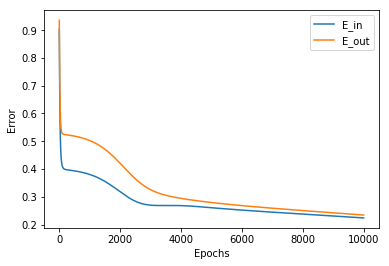

In [32]:
plt.plot(errors_GD_test)
plt.plot(errors_GD_train)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend(['E_in','E_out'])
#print(errors_GD_test)

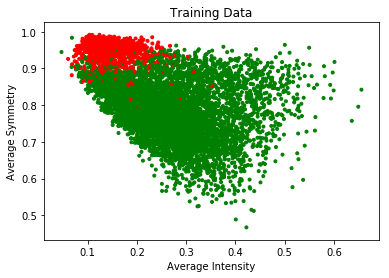

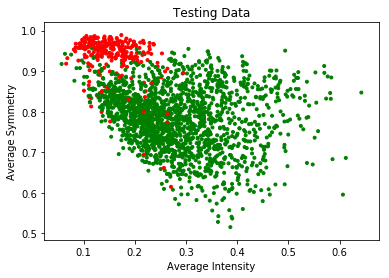

In [27]:
def Set_Colors_Array(true_labels):
    col = [None]*len(true_labels)
    for i in range(len(true_labels)):
        if int(true_labels[i]) == -1:
            col[i] = 'r'
        else:
            col[i] = 'g'
    return col
colors_train = Set_Colors_Array(d_2_train_labels_all)
colors_test = Set_Colors_Array(d_2_test_labels_all)
def Scatter_Plot(dataset,colors,title):           # Red = digit 2 and Green = digit 1
    x = dataset[:,0]
    y = dataset[:,1]
    plt.scatter(x,y,c= colors,marker='.')
    plt.xlabel('Average Intensity')
    plt.ylabel('Average Symmetry')
    plt.title(title)
    plt.show()
Scatter_Plot(d_2_train_dataset_all,colors_train,'Training Data')
Scatter_Plot(d_2_test_dataset_all,colors_test,'Testing Data')

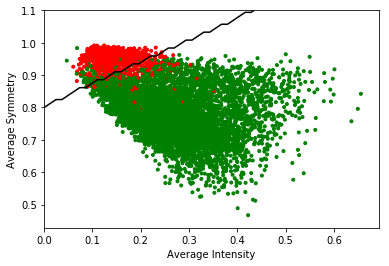

In [33]:
def Plot_Results(dataset,colors,W):
    x = dataset[:,0]
    y = dataset[:,1]
    plt.scatter(x,y,c= colors,marker='.')
    plt.xlabel('Average Intensity')
    plt.ylabel('Average Symmetry')
    #plt.title('Linear Regression Boundary for Digits 1 and '+str(digit))
    x_values = np.linspace(0,0.6)
    y_values = np.linspace(0.5,1.1)
    """https://stackoverflow.com/questions/36013063/what-is-the-purpose-of-meshgrid-in-python-numpy"""
    # Meshgrid creates rectangular grid with x axis steps defined by x array and y axis grid steps defined by y array
    x_grid,y_grid = np.meshgrid(x_values,y_values)
    data = np.c_[x_grid.ravel(),y_grid.ravel()]
    s_l = [0]* len(data)
    x_l = [0]* len(data)
    pred = [0]* len(data)
    for key,value in enumerate(data):
        x_n = np.empty((value.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = value
        s_l[key],x_l[key] = feedforward(x_n,W)
        if np.float32(x_l[key][-1][1:]) > 0:
            pred[key] = 1
        else:
            pred[key] = -1
    Z = np.array(pred).reshape(x_grid.shape)
    plt.contour(x_values,y_values,Z,[0],colors='k',linestyles='solid')
Plot_Results(d_2_train_dataset_all,colors_train,weight_list_new_GD)

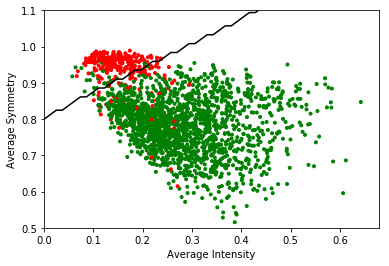

In [34]:
Plot_Results(d_2_test_dataset_all,colors_test,weight_list_new_GD)

In [14]:
def evaluate(test_data,test_labels,weight_list_new):
    cnt = 0
    for index,x in enumerate(test_data):
        x_n = np.empty((x.shape[0]+1,))
        x_n[0] = 1
        x_n[1:] = x
        x_l = feedforward(x_n,weight_list)[1]
        if x_l[-1][1] > 0 and test_labels[index] == 1:
            cnt += 1
        if x_l[-1][1] < 0 and test_labels[index] == -1:
            cnt += 1
    return cnt
cnt = evaluate(d_2_test_dataset,d_2_test_labels,weight_list_new_GD)

In [25]:
print('Accuracy on test data :',(cnt/len(d_2_test_dataset))*100)

Accuracy on test data : 97.0


Text(0,0.5,'log10(Error)')

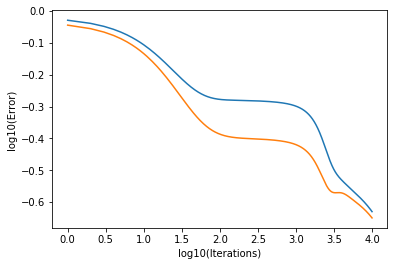

In [24]:
E_in_list = np.log10(errors_GD_train)
E_out_list = np.log10(errors_GD_test)
iters = np.log10([i for i in range(1,10001)])
plt.plot(iters,E_in_list)
plt.plot(iters,E_out_list)
plt.xlabel('log10(Iterations)')
plt.ylabel('log10(Error)')